In [ ]:
# importing the libraries and files

import math
from collections import Counter
from functools import reduce
import ast

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy import stats
import seaborn as sns
from statsmodels.stats import diagnostic

from src.data.utils import get_franchise_movies, get_franchise_data

# setting the color theme for the plots
sns.set_theme(style='darkgrid', palette='colorblind', color_codes=True)

In [ ]:
# loading the completed dataset
movies_df = pd.read_csv('data/movie_metadata_with_tmdb.csv')

# keeping only movies in franchises
franchise_df = get_franchise_movies(movies_df)

### Basic numerical analysis

In [ ]:
# Counting the number of movies per collections
franchise_counts = franchise_df.groupby(by='collection_id')['Wikipedia movie ID'].count()
print(franchise_counts.describe())
print(f"Number of movies in collections: {len(franchise_df['collection_id'])}")

count    1595.000000
mean        3.243260
std         3.751337
min         2.000000
25%         2.000000
50%         2.000000
75%         3.000000
max        66.000000
Name: Wikipedia movie ID, dtype: float64
Number of movies in collections: 5173


When importing the data, we decided to directly drop the franchises that had only one movie, as it would bias our analysis (it means that the other movies in the collections were not included in the dataset as they were released after 2016). 

Now, we have 1595 collections, with 5173 movies, which we deem enough. We also see a strong outlier that has 66 movies (the maximum).

### Basic visualization

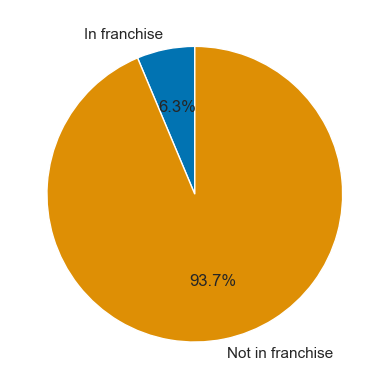

In [ ]:
proportion = len(franchise_df) / len(movies_df)
proportions = pd.DataFrame({'Proportion': [proportion, 1 - proportion]}, index=['In franchise', 'Not in franchise'])
explode = (0, 0.1)
fig, ax = plt.subplots()
ax.pie(proportions['Proportion'], labels=proportions.index, autopct='%1.1f%%', startangle=90)

plt.show()

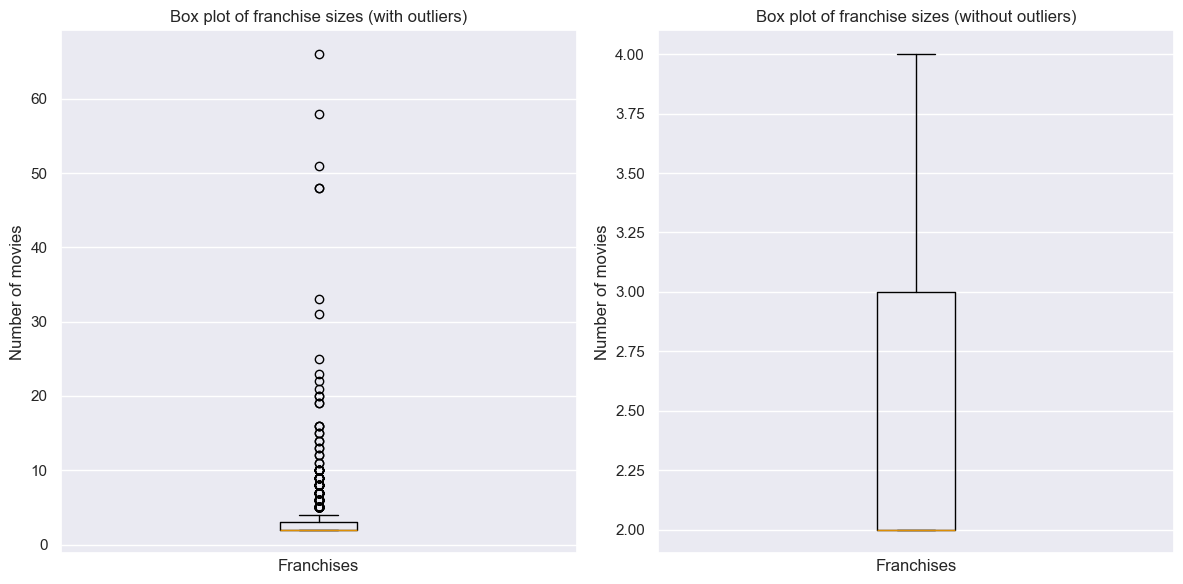

In [ ]:
# Plot the box plot
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Boxplot with outliers
axes[0].boxplot(franchise_counts)
axes[0].set_title('Box plot of franchise sizes (with outliers)')
axes[0].set_ylabel('Number of movies')
axes[0].set_xlabel('Franchises')
axes[0].set_xticks([])

# Boxplot without outliers
axes[1].boxplot(franchise_counts, showfliers=False)
axes[1].set_title('Box plot of franchise sizes (without outliers)')
axes[1].set_ylabel('Number of movies')
axes[1].set_xlabel('Franchises')
axes[1].set_xticks([])

plt.tight_layout()
plt.show()

Here, we can see that at least 75% of the franchises have between 2 and 4 movies. And when looking closely at the outliers, such as "Our gang: The Roach/Pathé silents (1922-1928)" with 66 movies, we see that they mostly do not correspond to sequels, but to franchises. This is something to keep in mind for the data analysis.

### Focusing on genres

Now, we wanted to look more closely at the genre columns, as it is one of the parameters needed to answer our research questions. First, let's plot the genre proportions in the original dataset, with all the movies.

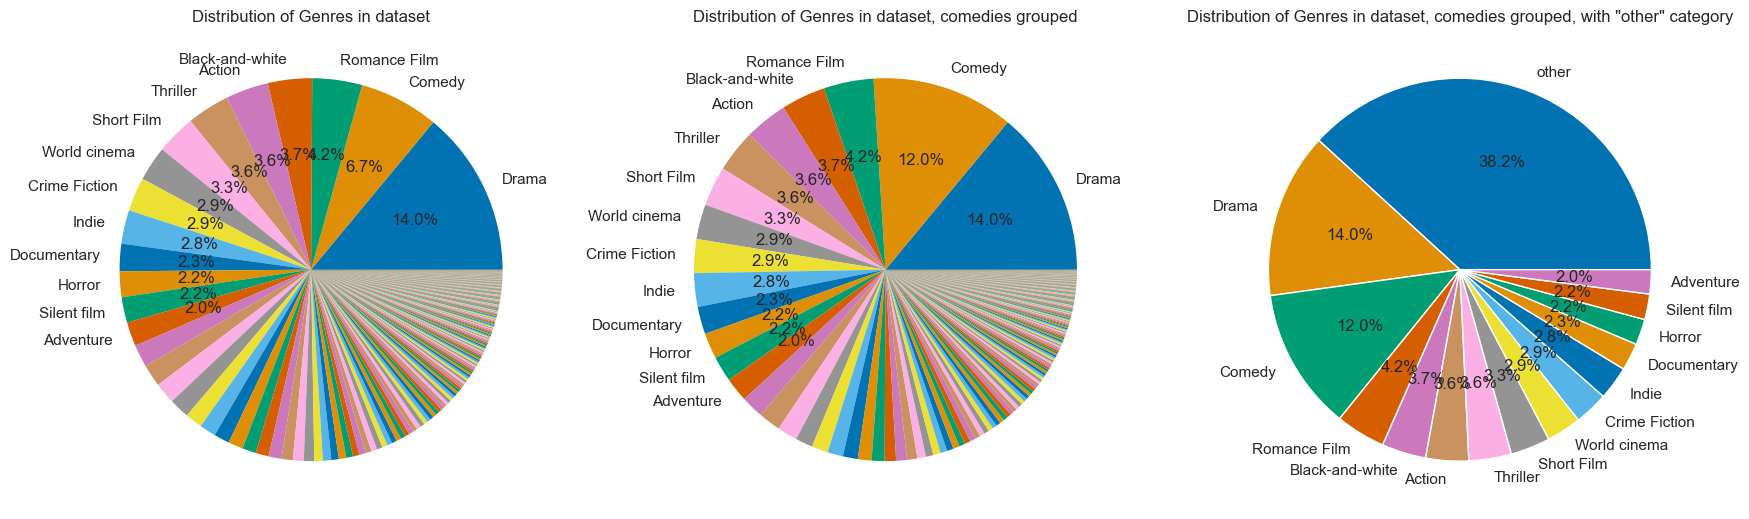

In [ ]:
genre_counts = Counter()

for genres in movies_df['Movie genres (Freebase ID:name tuples)']:
    if pd.notnull(genres):
        # Split the genres by comma and strip any extra spaces
        genre_list = [genre.split(":")[1].strip().replace("}", "") for genre in genres.split(",") if ":" in genre]
        genre_counts.update(genre_list)

genre_counts_df = pd.DataFrame.from_dict(genre_counts, orient='index', columns=['counts']).reset_index()
genre_counts_df.columns = ['genre', 'counts']
genre_counts_df['genre']=genre_counts_df['genre'].str.replace('}','')
genre_counts_df = genre_counts_df.sort_values(by='counts', ascending=False)
# Clean up genre names by removing double quotes
genre_counts_df['genre'] = genre_counts_df['genre'].str.replace('"', '')

# Calculate the total count of all genres
total_genres_count = genre_counts_df['counts'].sum()
# Determine the threshold count for 2%
threshold_count = total_genres_count * 0.02
# Replace genres with counts below the threshold with an empty string for labels
labels = genre_counts_df.apply(lambda row: '' if row['counts'] < threshold_count else row['genre'], axis=1)

# Plotting the pie chart with filtered labels
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(21, 10))

ax1.pie(genre_counts_df['counts'], labels=labels, autopct=lambda p: '' if p < 2 else f'{p:.1f}%', wedgeprops={'edgecolor': 'none'})
ax1.set_title('Distribution of Genres in dataset')

# Replace any genre containing "comedy" (case-insensitive) with "comedy"
genre_counts_df['genre'] = genre_counts_df['genre'].str.replace(r'(?i).*comedy.*', 'Comedy', regex=True)

# Group by genre and sum counts
old_genre_counts = genre_counts_df.groupby('genre', as_index=False)['counts'].sum()
old_genre_counts = old_genre_counts.sort_values(by='counts', ascending=False)
labels2 = old_genre_counts.apply(lambda row: '' if row['counts'] < threshold_count else row['genre'], axis=1)
# Plotting the pie chart
ax2.pie(old_genre_counts['counts'], labels=labels2, autopct=lambda p: '' if p < 2 else f'{p:.1f}%', wedgeprops={'edgecolor': 'none'})
ax2.set_title('Distribution of Genres in dataset, comedies grouped')

# Replace genres with counts below the threshold with "other"
old_genre_counts['genre'] = old_genre_counts.apply(lambda row: 'other' if row['counts'] < threshold_count else row['genre'], axis=1)
old_genre_counts = old_genre_counts.groupby('genre', as_index=False)['counts'].sum()
old_genre_counts = old_genre_counts.sort_values(by='counts', ascending=False)
# Plotting the pie chart
ax3.pie(old_genre_counts['counts'], labels=old_genre_counts['genre'], autopct='%1.1f%%')
ax3.set_title('Distribution of Genres in dataset, comedies grouped, with "other" category')

plt.show()

Now, let's compare with the distribution in the movies in franchises subset:

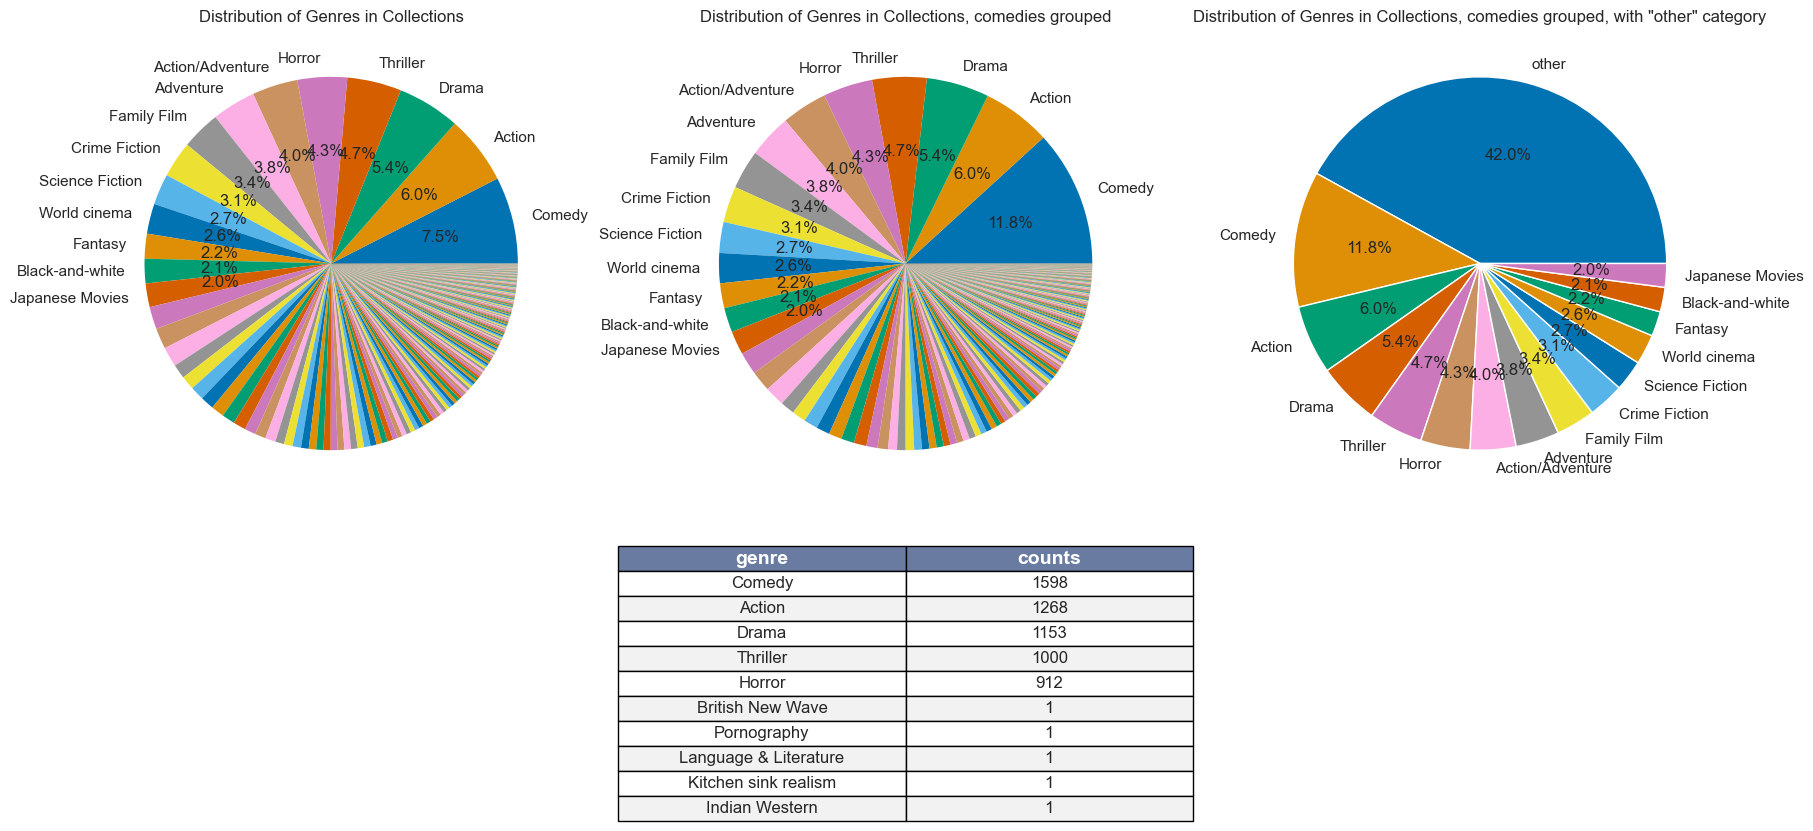

In [ ]:
genre_counts = Counter()

for genres in franchise_df['Movie genres (Freebase ID:name tuples)']:
    if pd.notnull(genres):
        # Split the genres by comma and strip any extra spaces
        genre_list = [genre.split(":")[1].strip().replace("}", "") for genre in genres.split(",") if ":" in genre]
        genre_counts.update(genre_list)

genre_counts_df = pd.DataFrame.from_dict(genre_counts, orient='index', columns=['counts']).reset_index()
genre_counts_df.columns = ['genre', 'counts']
genre_counts_df['genre']=genre_counts_df['genre'].str.replace('}','')
genre_counts_df = genre_counts_df.sort_values(by='counts', ascending=False)
# Clean up genre names by removing double quotes
genre_counts_df['genre'] = genre_counts_df['genre'].str.replace('"', '')

# Calculate the total count of all genres
total_genres_count = genre_counts_df['counts'].sum()
# Determine the threshold count for 2%
threshold_count = total_genres_count * 0.02
# Replace genres with counts below the threshold with an empty string for labels
labels = genre_counts_df.apply(lambda row: '' if row['counts'] < threshold_count else row['genre'], axis=1)

# Plotting the pie chart with filtered labels
fig = plt.figure(figsize=(21, 10))
gs = GridSpec(2, 3, height_ratios=[2, 1], width_ratios=[1, 1, 1])
ax1 = fig.add_subplot(gs[0, 0])
ax1.pie(genre_counts_df['counts'], labels=labels, autopct=lambda p: '' if p < 2 else f'{p:.1f}%', wedgeprops={'edgecolor': 'none'})
ax1.set_title('Distribution of Genres in Collections')

# Replace any genre containing "comedy" (case-insensitive) with "comedy"
genre_counts_df['genre'] = genre_counts_df['genre'].str.replace(r'(?i).*comedy.*', 'Comedy', regex=True)


# Group by genre and sum counts
old_genre_counts = genre_counts_df.groupby('genre', as_index=False)['counts'].sum()
old_genre_counts = old_genre_counts.sort_values(by='counts', ascending=False)
labels2 = old_genre_counts.apply(lambda row: '' if row['counts'] < threshold_count else row['genre'], axis=1)
# Plotting the pie chart
ax2 = fig.add_subplot(gs[0, 1])
ax2.pie(old_genre_counts['counts'], labels=labels2, autopct=lambda p: '' if p < 2 else f'{p:.1f}%', wedgeprops={'edgecolor': 'none'})
ax2.set_title('Distribution of Genres in Collections, comedies grouped')

# Replace genres with counts below the threshold with "other"
old_genre_counts['genre'] = old_genre_counts.apply(lambda row: 'other' if row['counts'] < threshold_count else row['genre'], axis=1)
old_genre_counts = old_genre_counts.groupby('genre', as_index=False)['counts'].sum()
old_genre_counts = old_genre_counts.sort_values(by='counts', ascending=False)
# Plotting the pie chart
ax3 = fig.add_subplot(gs[0, 2])
ax3.pie(old_genre_counts['counts'], labels=old_genre_counts['genre'], autopct='%1.1f%%')
ax3.set_title('Distribution of Genres in Collections, comedies grouped, with "other" category')

# Extract top 5 and bottom 5 genres
top_5_genres = genre_counts_df.head(5)
bottom_5_genres = genre_counts_df.tail(5)
# Combine top 5 and bottom 5 genres into a single DataFrame
top_bottom_genres = pd.concat([top_5_genres, bottom_5_genres])

# Plot the table with top 5 and bottom 5 genres
ax4 = fig.add_subplot(gs[1, 1])
ax4.axis('off')

# Create the table
table = ax4.table(cellText=top_bottom_genres.values,
                 colLabels=top_bottom_genres.columns,
                 cellLoc='center', loc='center')

# Customize table appearance
table.auto_set_font_size(False)
table.set_fontsize(12)  # Increase font size
table.scale(1.2, 1.5)  # Scale for better spacing

# Adding color to the header and rows
for (i, j), cell in table.get_celld().items():
    if i == 0:  # Header row
        cell.set_fontsize(14)
        cell.set_text_props(weight='bold')  # Make header text bold
        cell.set_facecolor('#6a7ba2')  # Green background for header
        cell.set_text_props(color='white')  # White text color for the header
    else:
        if i % 2 == 0:
            cell.set_facecolor('#f2f2f2')  # Light gray color for alternate rows
        else:
            cell.set_facecolor('#ffffff')  # White color for other rows

    # Set border style
    cell.set_edgecolor('black')  # Add black borders to cells

# Display the table
plt.show()

Now, we know that there are a lot of unique, very specific and irrelevant genres in the original categories (such as "Kitchen sink realism"), that appear less than 2% and together represent 42% of the whole genres. We therefore chose to use the ones in the added TMDB dataset.

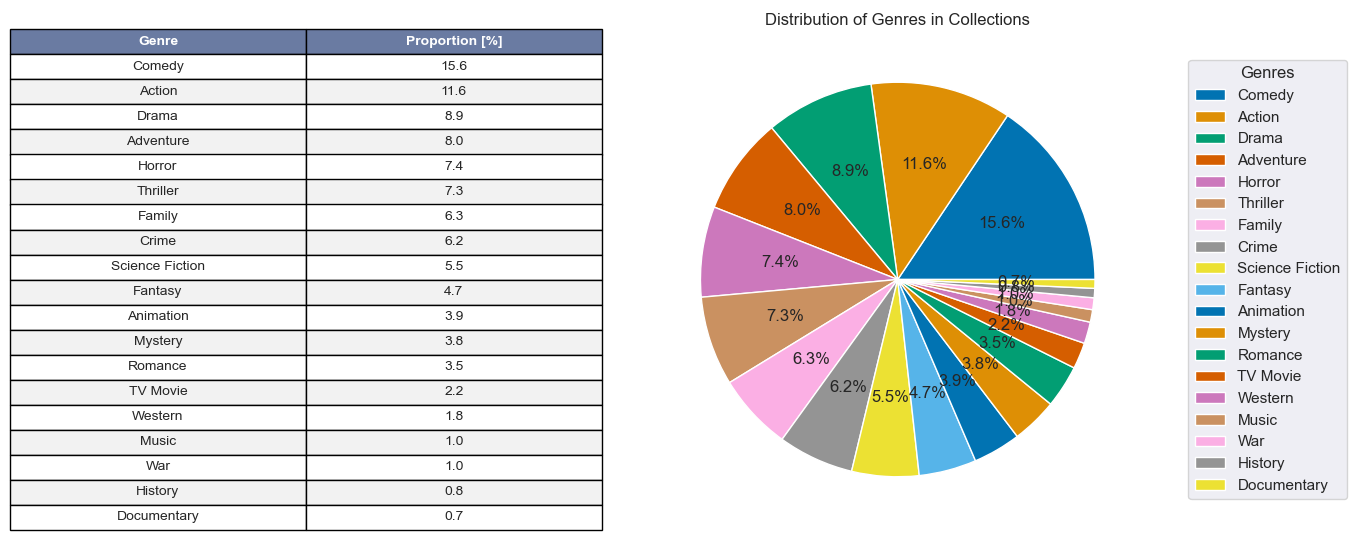

In [ ]:
# Function to extract genre names from the string representation of the list of dictionaries
def extract_genres(genres_str):
    try:
        genres_list = ast.literal_eval(genres_str)
        return [genre['name'] for genre in genres_list]
    except (ValueError, SyntaxError):
        return []

# Apply the function to the 'genres' column
franchise_df.loc[:, 'cleaned_genres'] = franchise_df['genres'].apply(extract_genres)

# Flatten the list of genres and count the occurrences
flattened_genres = [genre for sublist in franchise_df['cleaned_genres'] for genre in sublist]
genre_counts = Counter(flattened_genres)

# Convert the Counter object to a DataFrame for easier plotting
genre_counts_df = pd.DataFrame.from_dict(genre_counts, orient='index', columns=['count']).reset_index()
genre_counts_df.columns = ['genre', 'count']

# Calculate the proportion of each genre
genre_counts_df['proportion [%]'] = genre_counts_df['count'] / genre_counts_df['count'].sum() * 100
genre_counts_df = genre_counts_df.sort_values(by='proportion [%]', ascending=False)
genre_counts_df['proportion [%]'] = genre_counts_df['proportion [%]'].apply(lambda x: round(x, 1))

# Create a new figure with subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

# Plot the table with genre proportions
ax1.axis('off')
table = ax1.table(cellText=genre_counts_df[['genre', 'proportion [%]']].values,
                  colLabels=['Genre', 'Proportion [%]'],
                  cellLoc='center', loc='center')

# Customize table appearance
table.auto_set_font_size(False)
table.set_fontsize(12)  # Increase font size
table.scale(1.2, 1.5)  # Scale for better spacing

# Adding color to the header and rows
for (i, j), cell in table.get_celld().items():
    if i == 0:  # Header row
        cell.set_fontsize(14)
        cell.set_text_props(weight='bold')  # Make header text bold
        cell.set_facecolor('#6a7ba2')  # Green background for header
        cell.set_text_props(color='white')  # White text color for the header
    else:
        if i % 2 == 0:
            cell.set_facecolor('#f2f2f2')  # Light gray color for alternate rows
        else:
            cell.set_facecolor('#ffffff')  # White color for other rows

    # Set border style
    cell.set_edgecolor('black')  # Add black borders to cells

# Plot the pie chart with labels only on the side
wedges, texts, autotexts = ax2.pie(genre_counts_df['count'], labels=['']*len(genre_counts_df), autopct='%1.1f%%')
ax2.legend(wedges, genre_counts_df['genre'], title="Genres", loc="center", bbox_to_anchor=(1, 0, 0.5, 1))
ax2.set_title('Distribution of Genres in Collections')

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1., 1.)

plt.show()

This looks better ! And we still have the same top 3 genre ! Let's now compare our franchise movies to non franchise movies, to see if they seem to follow the same distribution:

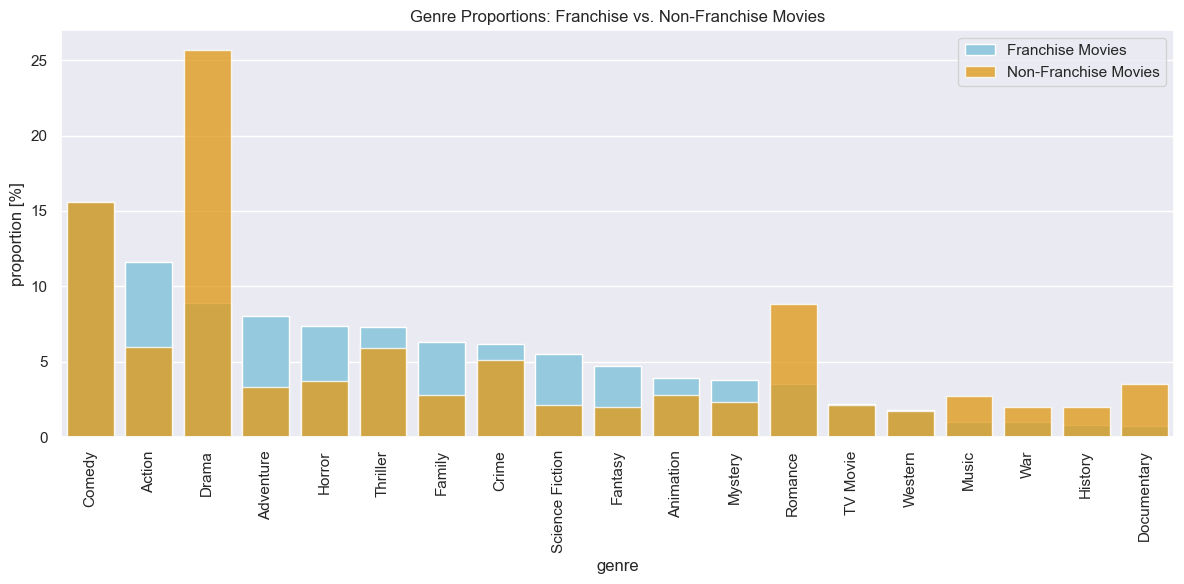

In [ ]:
# Extract movies not in franchise
non_franchise_df = movies_df[~movies_df['Wikipedia movie ID'].isin(franchise_df['Wikipedia movie ID'])].copy()

# Extract genres proportions for movies not in franchise, as done before
non_franchise_df.loc[:, 'cleaned_genres'] = non_franchise_df['genres'].apply(extract_genres)
nf_flattened_genres = [genre for sublist in non_franchise_df['cleaned_genres'] for genre in sublist]
nf_genre_counts = Counter(nf_flattened_genres)
nf_genre_counts_df = pd.DataFrame.from_dict(nf_genre_counts, orient='index', columns=['count']).reset_index()
nf_genre_counts_df.columns = ['genre', 'count']
nf_genre_counts_df['proportion [%]'] = nf_genre_counts_df['count'] / nf_genre_counts_df['count'].sum() * 100
nf_genre_counts_df = nf_genre_counts_df.sort_values(by='proportion [%]', ascending=False)
nf_genre_counts_df['proportion [%]'] = nf_genre_counts_df['proportion [%]'].apply(lambda x: round(x, 1))

# Set up the figure
plt.figure(figsize=(12, 6))

# Plot the higher bars (franchise) first
sns.barplot(
    x="genre", y="proportion [%]", data=genre_counts_df,
    color="skyblue", label="Franchise Movies"
)

# Plot the lower bars (non-franchise) second
sns.barplot(
    x="genre", y="proportion [%]", data=nf_genre_counts_df,
    color="orange", alpha=0.8, label="Non-Franchise Movies"
)

# Add labels, legend, and rotate x-axis labels for better visibility
plt.xticks(rotation=90)
plt.legend()
plt.title("Genre Proportions: Franchise vs. Non-Franchise Movies")
plt.tight_layout()

plt.show()


Here, we can see that Dramas are a lot more present (three times more) in non-franchise movies than in franchise movies. Why is that ? Do the viewers lose interest when they are presented multiple dramas in a row ? If so, how would that translate ? In worse ratings ? Less box-office revenues ? Let's dive deeper into these questions, and try to understand the disparities between franchise and non-franchise movies, as well as understanding what makes a saga successful.

now, we know this genre more represented, blabla, but is there a reason ? do they perform better ? attention à la normalisation !!
actual dramas and romance and ones that are less present in franchise, look at success and look at:
- if they are successful, are they often paired ? because we need to explain why they are so under-represented
- if they are not successful, end of analysis

### Box office analysis 

In [116]:
franchise_df = franchise_df.dropna(subset=['Movie box office revenue'])
movies_df = movies_df.dropna(subset=['Movie box office revenue'])
print(franchise_df['collection_id'].value_counts())

collection_id
645.0       22
9735.0      11
1241.0       8
656.0        7
534673.0     7
            ..
168186.0     1
745296.0     1
94589.0      1
99606.0      1
166379.0     1
Name: count, Length: 667, dtype: int64


If we clean the data set toward the box office datas, of the franchise movies (erease missing values), one can see that some franchise does not have this value for all its movies. 

In [117]:
movies_no_franchise = movies_df.copy()[movies_df['collection_id'].isna()]
#movie_box = data_no_coll.dropna(subset=['Movie box office revenue'])
print(movies_no_franchise['Movie box office revenue'].describe())


count    6.929000e+03
mean     3.124319e+07
std      6.867860e+07
min      1.000000e+04
25%      1.750000e+06
50%      7.706368e+06
75%      2.886208e+07
max      2.185372e+09
Name: Movie box office revenue, dtype: float64


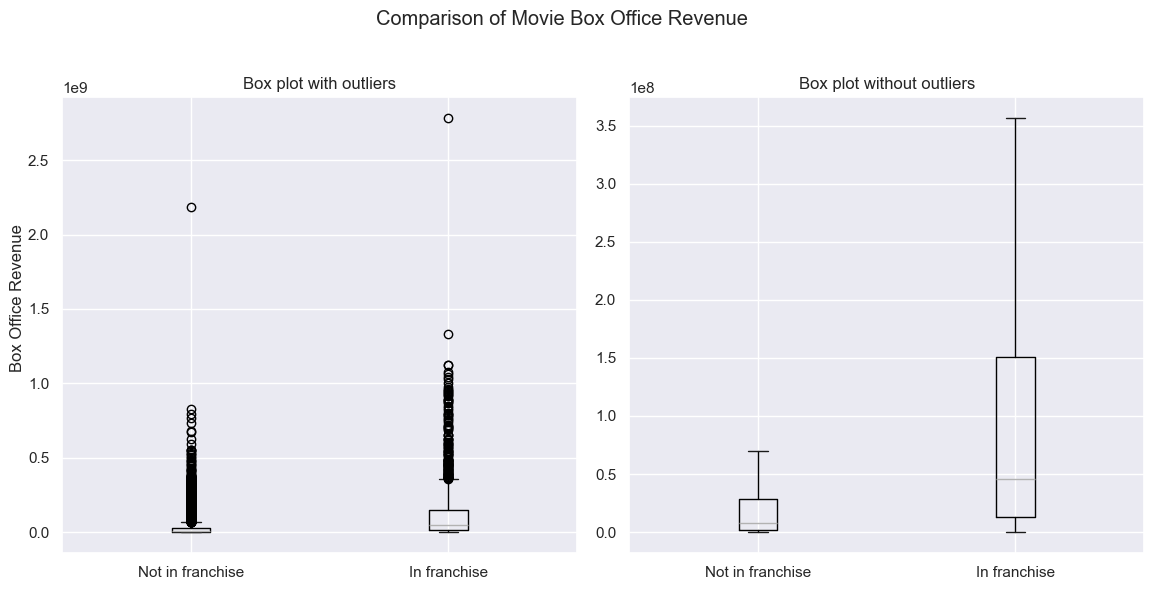

In [118]:
all_box= pd.DataFrame({
        'Not in franchise': movies_no_franchise['Movie box office revenue'], #movie_box['Movie box office revenue'],
        'In franchise': franchise_df['Movie box office revenue'] # box_office_df['Movie box office revenue']
        })

#Box plot to compare Movie box office in film that are in franchise and those that are not
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
# Plot with outliers
all_box.boxplot(ax=axes[0])
axes[0].set_title('Box plot with outliers')
    
# Plot without outliers
all_box.boxplot(ax=axes[1], showfliers=False)
axes[1].set_title('Box plot without outliers')
    
fig.text(0.04, 0.5, 'Box Office Revenue', va='center', rotation='vertical')
plt.suptitle('Comparison of Movie Box Office Revenue')
plt.tight_layout(rect=[0.04, 0, 1, 0.96])
plt.show()



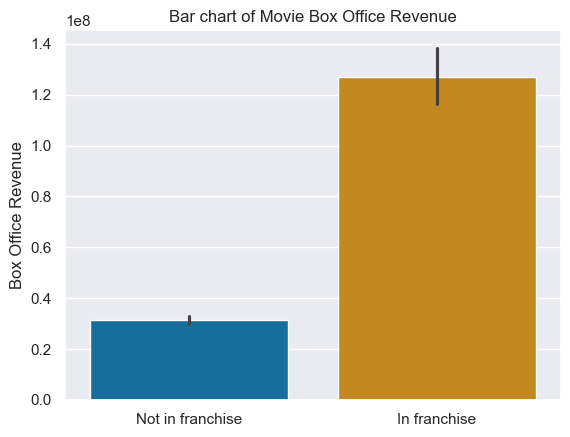

In [119]:
ax = sns.barplot(data=all_box)
plt.title('Bar chart of Movie Box Office Revenue')
plt.ylabel('Box Office Revenue')
plt.show()

<Figure size 1000x1000 with 0 Axes>

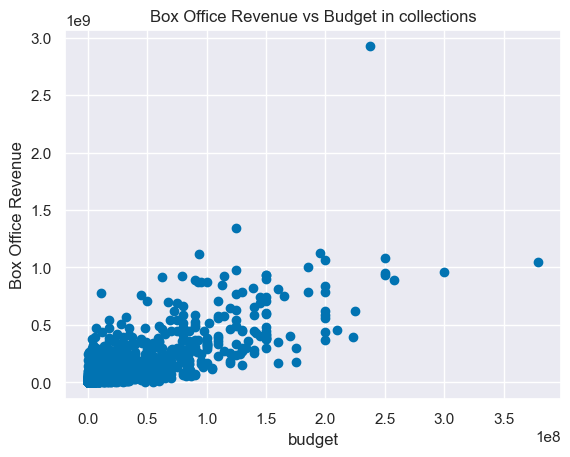

<Figure size 1000x1000 with 0 Axes>

In [120]:
#Formating the box office and budget values 
plt.scatter(franchise_df['budget'], franchise_df['revenue'])
plt.ylabel('Box Office Revenue')
plt.xlabel('budget')
plt.title('Box Office Revenue vs Budget in collections')
plt.figure(figsize=(10, 10))


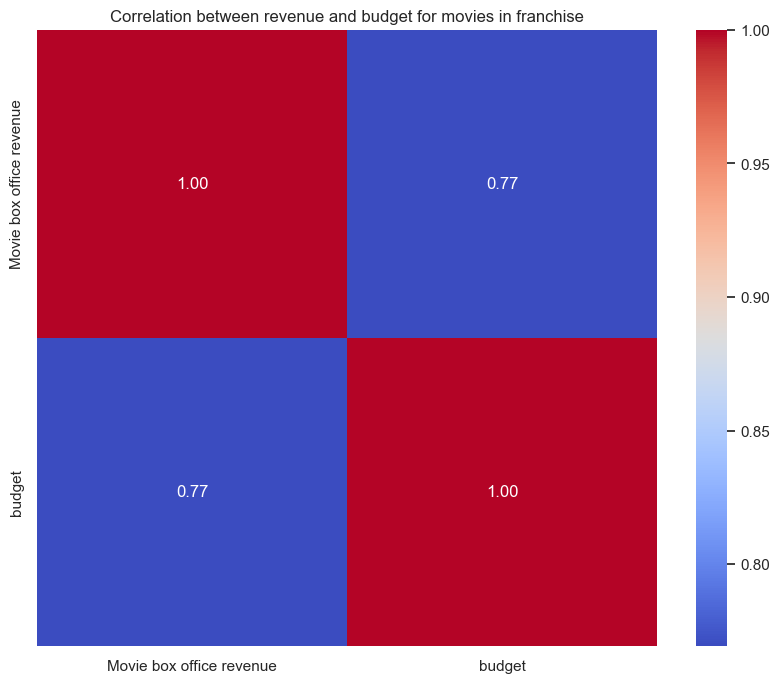

                          Movie box office revenue    budget
Movie box office revenue                  1.000000  0.769508
budget                                    0.769508  1.000000


In [121]:
def correlation_revenue_budget(df,title):
    # Calculate the correlation between 'budget' and 'revenue'
    numerical_df = df.select_dtypes(include='number').drop(columns=['ratio_box_budget','Freebase movie ID','Movie name','Movie release date','vote_count','release_year','run_time','nbr_movie_per_col','movie_order','tmdb_id','cote_count','vote_average','Movie runtime','Wikipedia movie ID','collection_name',	'collection_id','revenue'], errors='ignore')
    correlation_matrix = numerical_df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
    plt.title(title)
    plt.show()
    print(correlation_matrix)
    return correlation_matrix

franchise_correlation=correlation_revenue_budget(franchise_df,"Correlation between revenue and budget for movies in franchise")


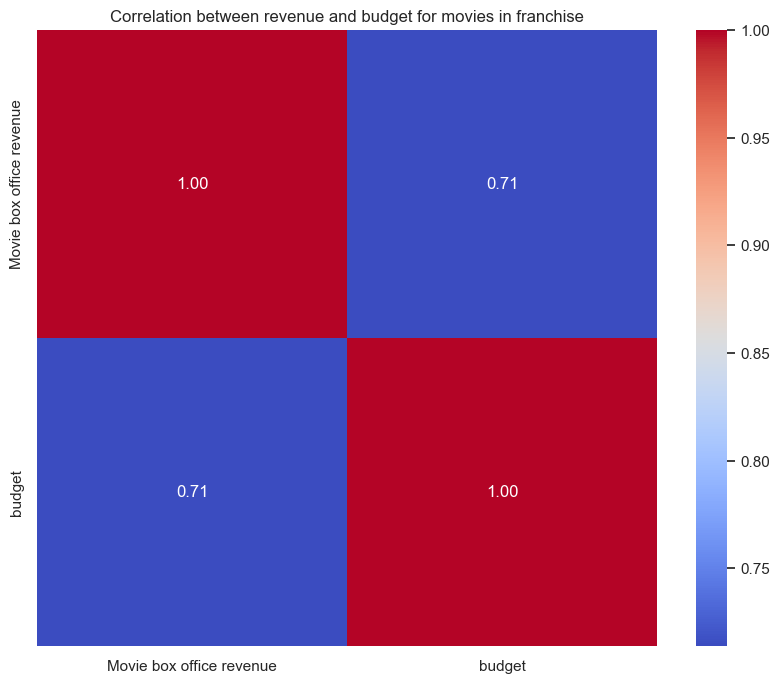

                          Movie box office revenue    budget
Movie box office revenue                  1.000000  0.714064
budget                                    0.714064  1.000000


<Figure size 1000x1000 with 0 Axes>

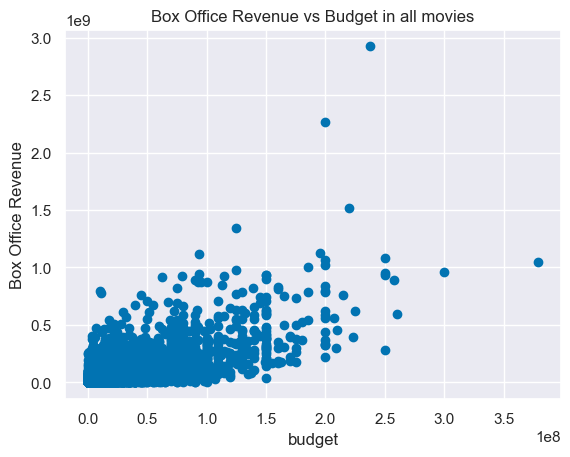

<Figure size 1000x1000 with 0 Axes>

In [122]:
movies_correlation=correlation_revenue_budget(movies_df,"Correlation between revenue and budget for movies in franchise")
plt.scatter(movies_df['budget'], movies_df['revenue'])
plt.ylabel('Box Office Revenue')
plt.xlabel('budget')
plt.title('Box Office Revenue vs Budget in all movies')
plt.figure(figsize=(10, 10))


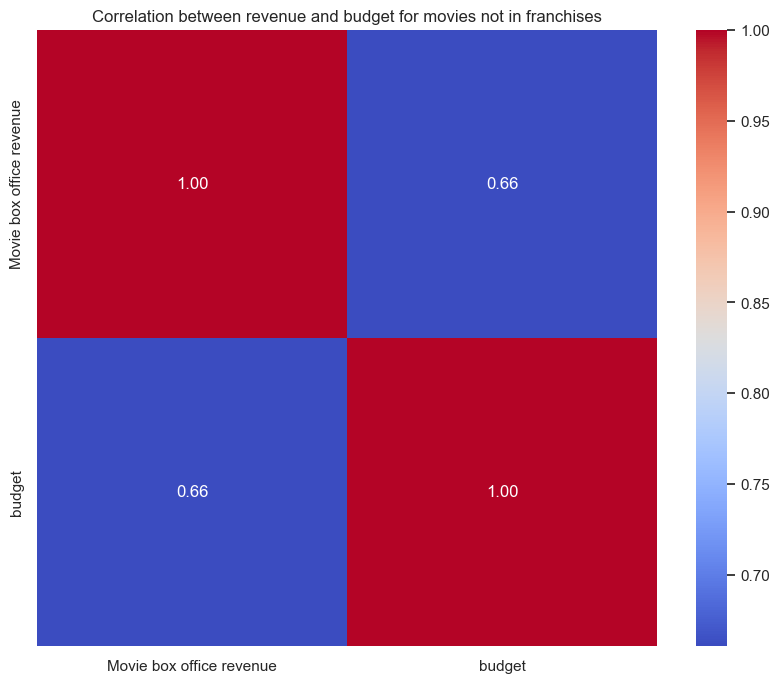

                          Movie box office revenue    budget
Movie box office revenue                  1.000000  0.661134
budget                                    0.661134  1.000000


<Figure size 1000x1000 with 0 Axes>

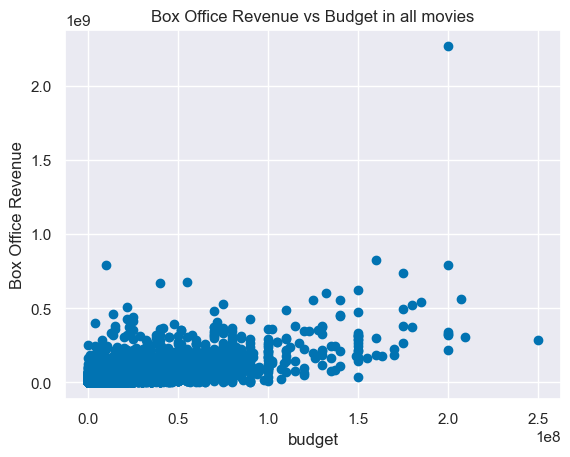

<Figure size 1000x1000 with 0 Axes>

In [123]:
movies_not_in_franchise_correlation=correlation_revenue_budget(movies_no_franchise,"Correlation between revenue and budget for movies not in franchises")
plt.scatter(movies_no_franchise['budget'], movies_no_franchise['revenue'])
plt.ylabel('Box Office Revenue')
plt.xlabel('budget')
plt.title('Box Office Revenue vs Budget in all movies')
plt.figure(figsize=(10, 10))

The linear correlation between movie revenue and movie budget increase for movies in franchise  

In [124]:
#Formating the date in all the data set 
franchise_df['Movie release date corrected'] = pd.to_datetime(franchise_df['Movie release date'],format='mixed',yearfirst=True)
franchise_df['release_year'] = franchise_df['Movie release date corrected'].dt.year
movies_df['Movie release date'] = pd.to_datetime(movies_df['Movie release date'], errors='coerce')
movies_df['release_year'] = movies_df['Movie release date'].dt.year

franchise_df['movie_order']=franchise_df.groupby('collection_id')['release_year'].rank(ascending=True)
#cleaning the data 
franchise_df['release_year'].dropna()

#Formating the box office and budget values 
def scientific_notation(x):
    return "{:.2e}".format(x)

franchise_df['budget'] = pd.to_numeric(franchise_df['budget'])
franchise_df['Movie box office revenue'] = pd.to_numeric(franchise_df['Movie box office revenue'])
franchise_df['budget'] = franchise_df['budget'].apply(scientific_notation)
franchise_df['Movie box office revenue']= franchise_df['Movie box office revenue'].apply(scientific_notation)




In [125]:
import plotly.express as px
import plotly.graph_objects as go
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
#conda install -c plotly plotly=5.24.1 

app = dash.Dash(__name__)
app.layout = html.Div([
    dcc.Dropdown(
        id="dropdown",
        options=[{'label': name, 'value': name} for name in franchise_df['collection_name'].unique()],
        value='Star Wars Collection',
        clearable=False,
    ),
    dcc.Graph(id="graph"),
])

@app.callback(
    Output("graph", "figure"), 
    Input("dropdown", "value"))
def collection_budget_box(collection_name):
    df = franchise_df[franchise_df['collection_name'] == collection_name]

    fig = px.scatter(df, x='budget', y='revenue', text='movie_order' ,title=f"{df['collection_name'].iloc[0]}")
    fig.update_traces(marker=dict(size=10), selector=dict(mode='markers+text'),textposition='top right')

    fig.update_layout(
        xaxis_title='Budget',
        yaxis_title='Box Office Revenue',
        legend_title_text='Movie Name',
        legend=dict(x=1.05, y=1, traceorder='normal')
    )
    return fig

app.run_server(debug=True)
